In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx

Import qiskit utilities (assumes you have cloned it into a folder in the ../ directory)

In [2]:
import sys
sys.path.append('../')

from qiskit_utilities.utilities import *
from optimization.qaoa import *

Import functions for error mitigation using zero noise extrapolation

In [3]:
from zero_noise_extrapolation import *

Define a function creating the 5qubit GHZ state circuit and plot it

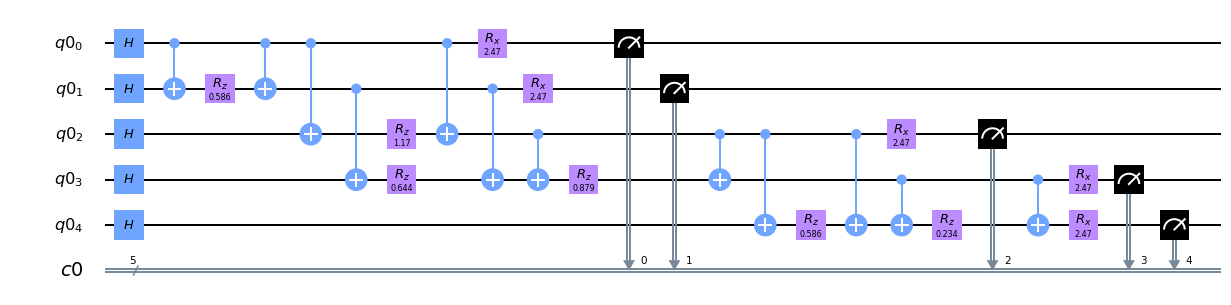

In [4]:
V = np.arange(0,5,1)
E =[(0,1,1.0),(0,2,2.0),(2,3,1.5),(3,1,1.1),(3,4,0.4),(4,2,1.0)]

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

version=1
circuit=createCircuit_MaxCut(np.array((0.58570312, 1.23378906)),G,1,version)

circuit.draw(output='mpl')

Create dictionaries for backends, noisemodels, basis gates and cx error maps

In [5]:
backends_dict={}
noisemodels_dict={}
basis_gates_dict={}
cx_error_maps_dict={}

Populate backends with 1) local simulator, 2) IBM's QX2 device, 3) IBM's Ourense device

In [6]:
backendname_sim = 'qasm_simulator'
backends_dict[backendname_sim] = Aer.get_backend(backendname_sim)

#load IBMQ account
#IBMQ.save_account('yourAPItoken')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

backendname_x2 = 'ibmqx2'
backendname_ourense = 'ibmq_ourense'

for backendname in [backendname_x2, backendname_ourense]:
    backends_dict[backendname] = provider.get_backend(backendname)

For the simulator, create noise models, cx error maps, basis gates for IBM's QX2, and Ourense device

In [7]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.device import basic_device_noise_model

for backendname in [backendname_x2, backendname_ourense]:
    backend = backends_dict[backendname]

    noisemodels_dict[backendname] = basic_device_noise_model(backend.properties())
    cx_error_maps_dict[backendname] = get_cx_error_map(backend)
    basis_gates_dict[backendname] = noisemodels_dict[backendname].basis_gates

noisemodels_dict['None'] = None

define a function for the expectation value

In [8]:
def expectationValue(data):
    global G
    E=[]
    V = list(G.nodes)
    num_qubits = len(V)
    for item in range(0,len(data)):
        shots = data[item].shots
        counts = data[item].data.counts
        E.append(0)
        for key in list(counts.__dict__.keys()):
            c=getattr(counts, key)#number of counts
            binstring="{0:b}".format(int(key,0)).zfill(num_qubits)
            y=[int(i) for i in binstring]
            E[item] += cost_MaxCut(y,G)*c/shots
    return E

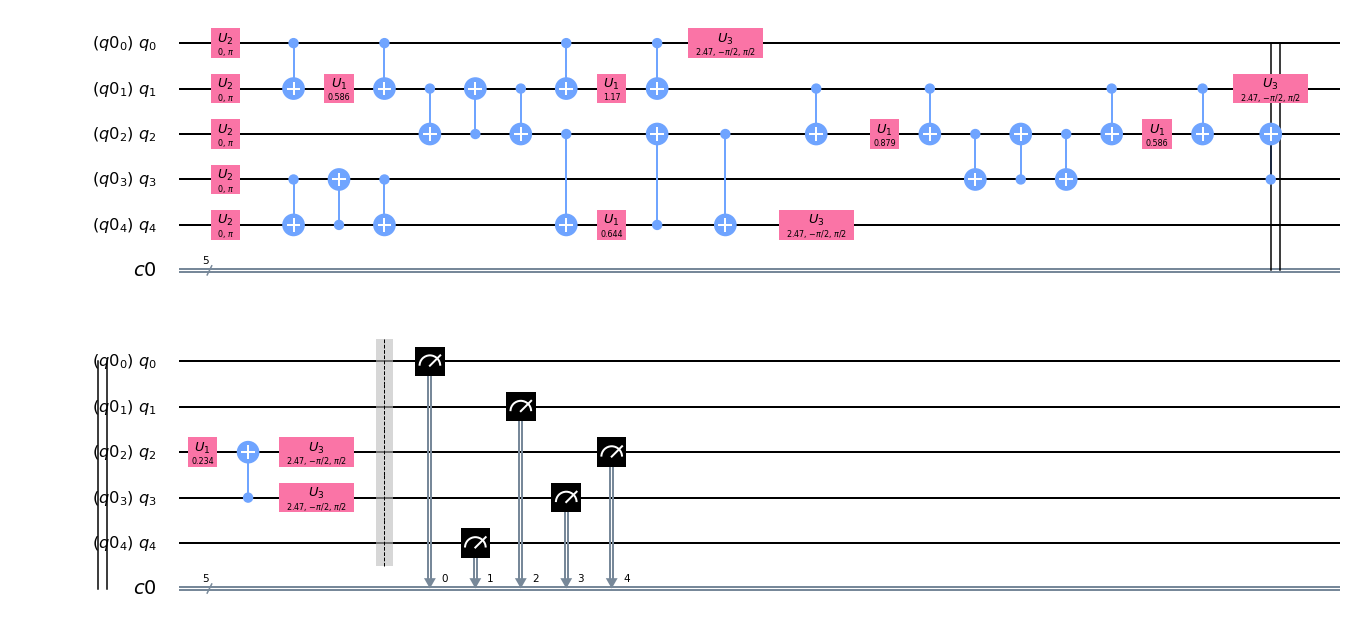

In [9]:
t_circuit=transpile(circuit,backends_dict[backendname_x2],optimization_level=1)
t_circuit.draw(output='mpl')

Mitigate the result of the simulator with a noise model

In [10]:
R,E_dict,E_av_dict,\
max_depth_dict,mean_depth_dict,\
max_depth_transpiled_dict,mean_depth_transpiled_dict,\
bn=\
mitigate(t_circuit, [1,2,4,8,16,32],\
             expectationValue,\
             backends_dict[backendname_sim], \
             "MaxCutHouse", cx_error_maps_dict[backendname_x2],\
             8192, 1024,\
             backends_dict[backendname_x2],\
             noisemodels_dict[backendname_x2],\
             basis_gates_dict[backendname_x2],\
             )
print("Expectation value without error mitigation E = ",E_av_dict[bn+"_r1"][-1])
print("Expectation value with error mitigation E = ",R[-1][0])

Sanity checks passed
Result for job ' MaxCutHouse_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r1 ' successfully read from disk
Result for job ' MaxCutHouse_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r2 ' successfully read from disk
Result for job ' MaxCutHouse_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r4 ' successfully read from disk
Result for job ' MaxCutHouse_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r8 ' successfully read from disk
Result for job ' MaxCutHouse_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r16 ' successfully read from disk
Result for job ' MaxCutHouse_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r32 ' successfully read from disk
Expectation value without error mitigation E =  4.1898708820343025
Expectation value with error mitigation 

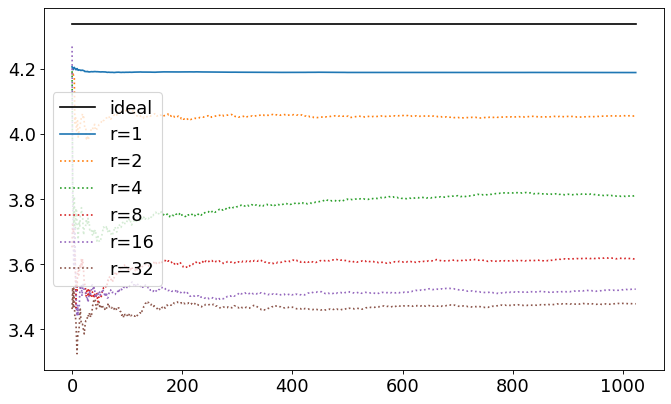

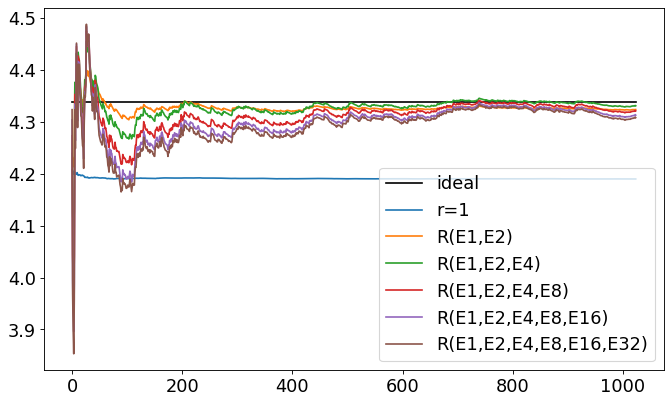

In [11]:
idealvalue=4.338232
font = {'size' : 16}
pl.matplotlib.rc('font', **font);
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(idealvalue+0*E_av_dict[bn+"_r1"],'k',label='ideal')
pl.plot(E_av_dict[bn+"_r1"],label='r=1')
pl.plot(E_av_dict[bn+"_r2"],':',label='r=2')
pl.plot(E_av_dict[bn+"_r4"],':',label='r=4')
pl.plot(E_av_dict[bn+"_r8"],':',label='r=8')
pl.plot(E_av_dict[bn+"_r16"],':',label='r=16')
pl.plot(E_av_dict[bn+"_r32"],':',label='r=32')
#pl.ylim(2.46,2.505)
pl.legend();

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(idealvalue+0*E_av_dict[bn+"_r1"],'k',label='ideal')
pl.plot(E_av_dict[bn+"_r1"],label='r=1')

R12=Richardson_extrapolate(np.array([E_av_dict[bn+"_r1"],\
                                     E_av_dict[bn+"_r2"]]),\
                           np.array([1,2]))
pl.plot(R12,label='R(E1,E2)')

R124=Richardson_extrapolate(np.array([E_av_dict[bn+"_r1"],\
                                     E_av_dict[bn+"_r2"],\
                                     E_av_dict[bn+"_r4"]]),\
                           np.array([1,2,4]))
pl.plot(R124,label='R(E1,E2,E4)')

R1248=Richardson_extrapolate(np.array([E_av_dict[bn+"_r1"],\
                                     E_av_dict[bn+"_r2"],\
                                     E_av_dict[bn+"_r4"],\
                                     E_av_dict[bn+"_r8"]]),\
                           np.array([1,2,4,8]))
pl.plot(R1248,label='R(E1,E2,E4,E8)')

R124816=Richardson_extrapolate(np.array([E_av_dict[bn+"_r1"],\
                                     E_av_dict[bn+"_r2"],\
                                     E_av_dict[bn+"_r4"],\
                                     E_av_dict[bn+"_r8"],\
                                     E_av_dict[bn+"_r16"]]),\
                           np.array([1,2,4,8,16]))
pl.plot(R124816,label='R(E1,E2,E4,E8,E16)')

pl.plot(R,label='R(E1,E2,E4,E8,E16,E32)')
#pl.ylim(2.46,2.505)
pl.legend();

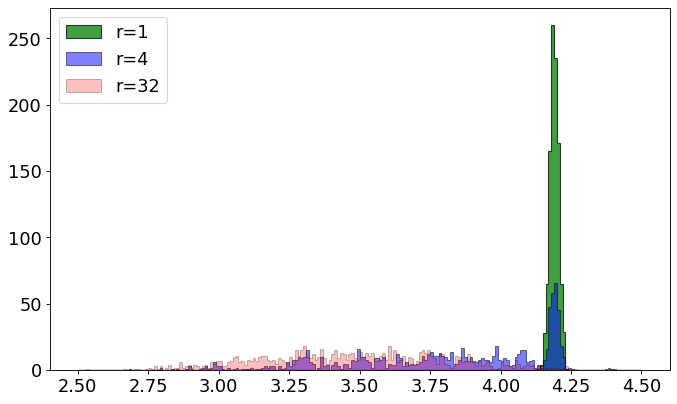

In [12]:
xmin=2.5
xmax=4.5
numbins=200
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
d=pl.hist(E_dict[bn+"_r1"],edgecolor = 'black',color='green',range=(xmin,xmax),bins=numbins,\
                 alpha=.75,histtype='stepfilled',label='r=1')
d=pl.hist(E_dict[bn+"_r4"],edgecolor = 'black',color='blue',range=(xmin,xmax),bins=numbins,\
                 alpha=0.5,histtype='stepfilled',label='r=4')
d=pl.hist(E_dict[bn+"_r32"],edgecolor = 'black',color='red',range=(xmin,xmax),bins=numbins,\
                 alpha=0.25,histtype='stepfilled',label='r=32')
pl.legend(loc='upper left');

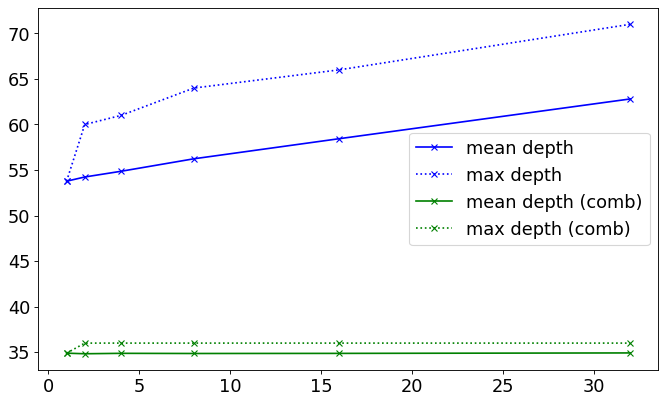

In [13]:
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(np.array([1,2,4,8,16,32]),(mean_depth_dict[bn+"_r1"],\
        mean_depth_dict[bn+"_r2"],\
        mean_depth_dict[bn+"_r4"],\
        mean_depth_dict[bn+"_r8"],\
        mean_depth_dict[bn+"_r16"],\
        mean_depth_dict[bn+"_r32"]),'bx-',label='mean depth')
pl.plot(np.array([1,2,4,8,16,32]),(mean_depth_dict[bn+"_r1"],\
        max_depth_dict[bn+"_r2"],\
        max_depth_dict[bn+"_r4"],\
        max_depth_dict[bn+"_r8"],\
        max_depth_dict[bn+"_r16"],\
        max_depth_dict[bn+"_r32"]),'bx:',label='max depth')
pl.plot(np.array([1,2,4,8,16,32]),(mean_depth_transpiled_dict[bn+"_r1"],\
        mean_depth_transpiled_dict[bn+"_r2"],\
        mean_depth_transpiled_dict[bn+"_r4"],\
        mean_depth_transpiled_dict[bn+"_r8"],\
        mean_depth_transpiled_dict[bn+"_r16"],\
        mean_depth_transpiled_dict[bn+"_r32"]),'gx-',label='mean depth (comb)')
pl.plot(np.array([1,2,4,8,16,32]),(mean_depth_transpiled_dict[bn+"_r1"],\
        max_depth_transpiled_dict[bn+"_r2"],\
        max_depth_transpiled_dict[bn+"_r4"],\
        max_depth_transpiled_dict[bn+"_r8"],\
        max_depth_transpiled_dict[bn+"_r16"],\
        max_depth_transpiled_dict[bn+"_r32"]),'gx:',label='max depth (comb)')
pl.legend();